<h1><center>CS5200 Computer Architecture - Project 1</center></h1>
<h3><center>Authors: Smita Khapre, Carlos Torres and Kevin Cardenas</center></h3>

#### Team Member Primary Contributions
- Smita: Virtual machine environment setup, bash script writing, and gem5 simulations
- Carlos: Priority queue implementations in C, created Makefile, assembly file analysis, and project submission
- Kevin: Team leader, setup github and team roles/responsibilities, wrote data scraping script, and report writeup

## 0. Project Background
In this project we used the gem5 simulator to run an experiment changing features of the pipeline, functional units, and compiler optimization (loop unrolling) and evaluated the sensitivity of changing these features. Multiple response variables were collected to evaluate the performance of the different combinations of features. These responses are simulation time, L1 cache misses, and the number of times a loop was unrolled. 
- **CPU:** TimeSimpleCPU, X86MinorCPU
- **Cache Sizes:** 64kB Direct-Mapped L1 Data Cache, 32kB Direct-Mapped L1 Instruction Cache, 4MB 8-way Unified L2 Cache
- **Functional Units (Operation Latency, Issue Latency):** (6, 1), (5, 2), (4, 3), (3, 4), (2, 5), (1, 6)
- **Loop Unrolling:** Not Included, Included

Additionally, each of these architectures were run using two implementations of a priority queue:
- `pq-linklist.c`
- `pq-minheap.c`

In [1]:
import read_data
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_rows', None)

## 1. Import Data
A bash script was utilized to run all of the configurations of our simulation. This script also included functionality to create and save the `stats.txt` files in a file folder hierarchy. After running all of the experiments in gem5, the file structure containing all of the `stats.txt` output files was copied from the Docker container to the team's GitHub repository. A second script was created to read in the `stats.txt` files contained in the file structure and save the data into three pandas DataFrames. The first DataFrame contains the data for Part 1, the second for Part 2 and the third for Parts 3-5.

In [2]:
df1, df2, df = read_data.read_data()

## 2. Instruction Breakup
### Question 1: What is the breakup of instructions? 
Part 1 and Part 2 (`p1` and `p2`, respectively) were both run to provide baseline results using the TimingSimpleCPU, the baseline functional units (1 operation latency and 1 issue latency), and without using any cache. The only difference between the two parts is that `p1` tracked the descriptive statistics for the entire program, where `p2` tracked the statistics for three portions of the program: before the sorting loop, the sorting loop, after the sorting loop. We will call these three portions of code Part 2a, Part 2b, and Part2c, respectively. 

In order to quickly inspect the breakup of instructions for each of our priority queue implementations, a bar plot was used. These plots compare the instruction breakup for each priority queue type using `p1` and `p2`.

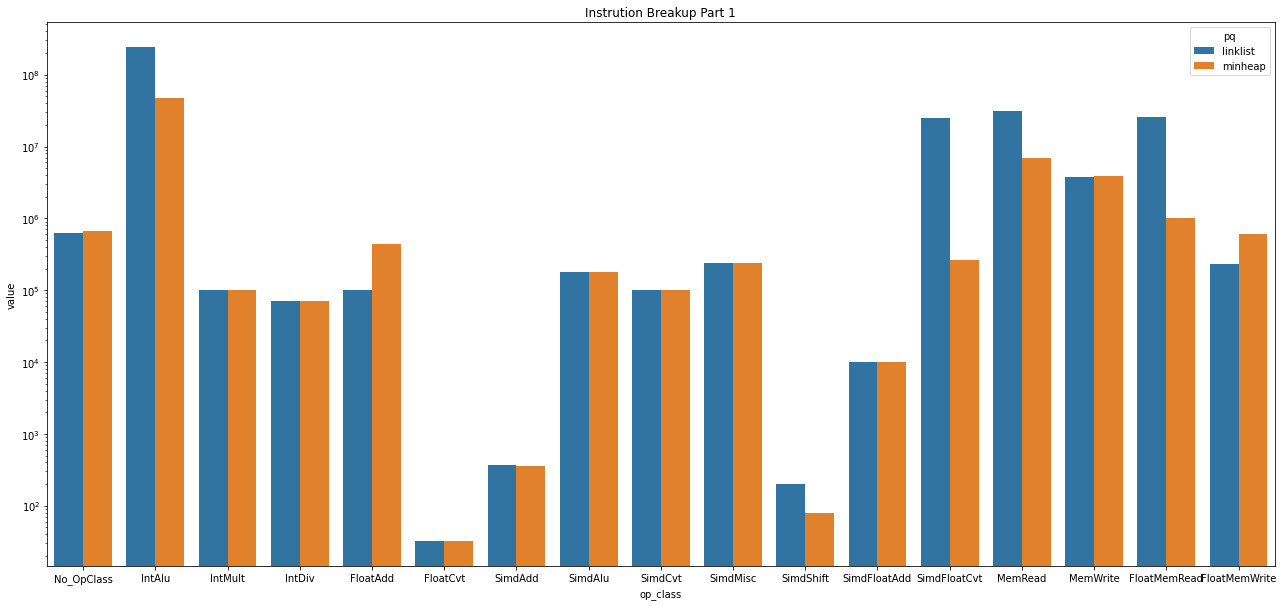

In [3]:
plt.rcParams["figure.figsize"] = (22, 10)
sns.barplot(data=df1, x='op_class', y='value', hue='pq', log=True)
plt.title("Instrution Breakup Part 1")
plt.show()

The first, and most obvious, observation is that the `IntALU` instructions are the overwhelming majority of all instructions, nearly tenfold. The next observation is that the `linklist` implementation performs far more memory reads (`MemRead` and `FloatMemRead`), as well as `IntALU` and `SimdFloatCvt` compared to `minheap`. The `minheap` implementation perfoms more `FloatAdd` and `FloatMemWrite` instructions, but overall performs far less instructions compared to `linklist`.

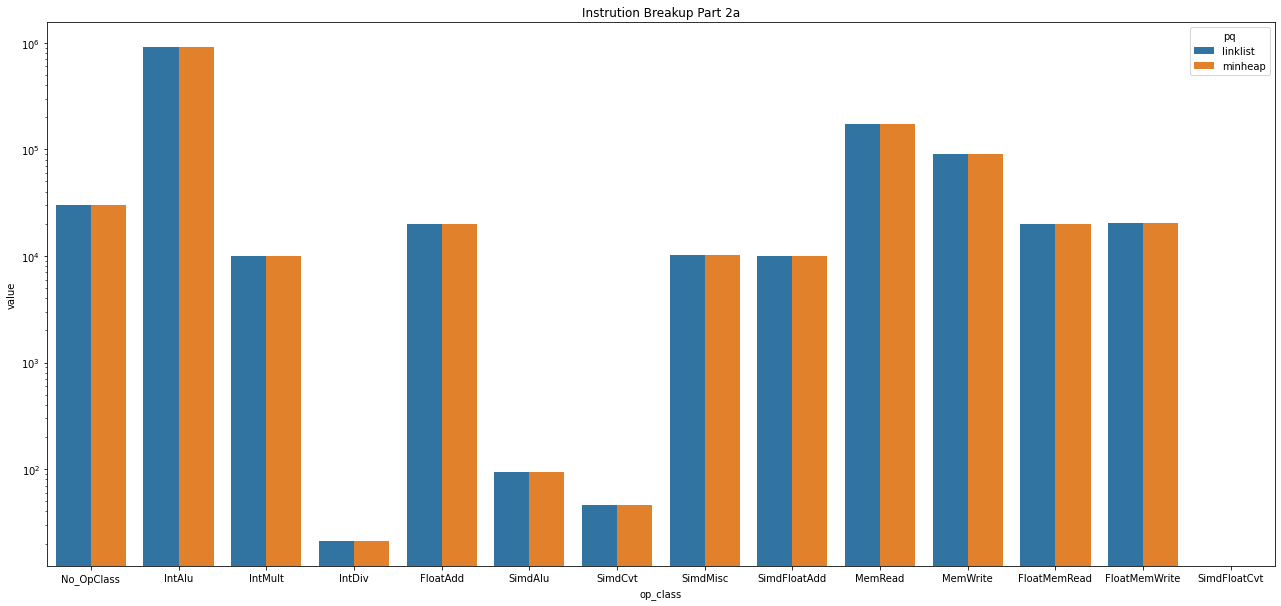

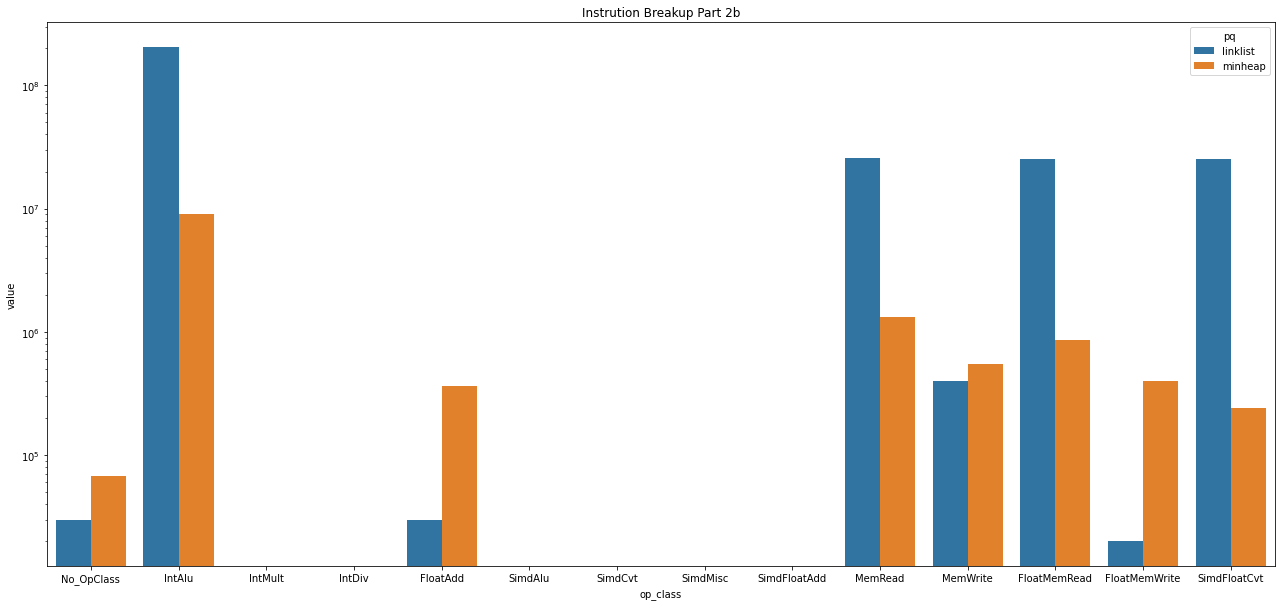

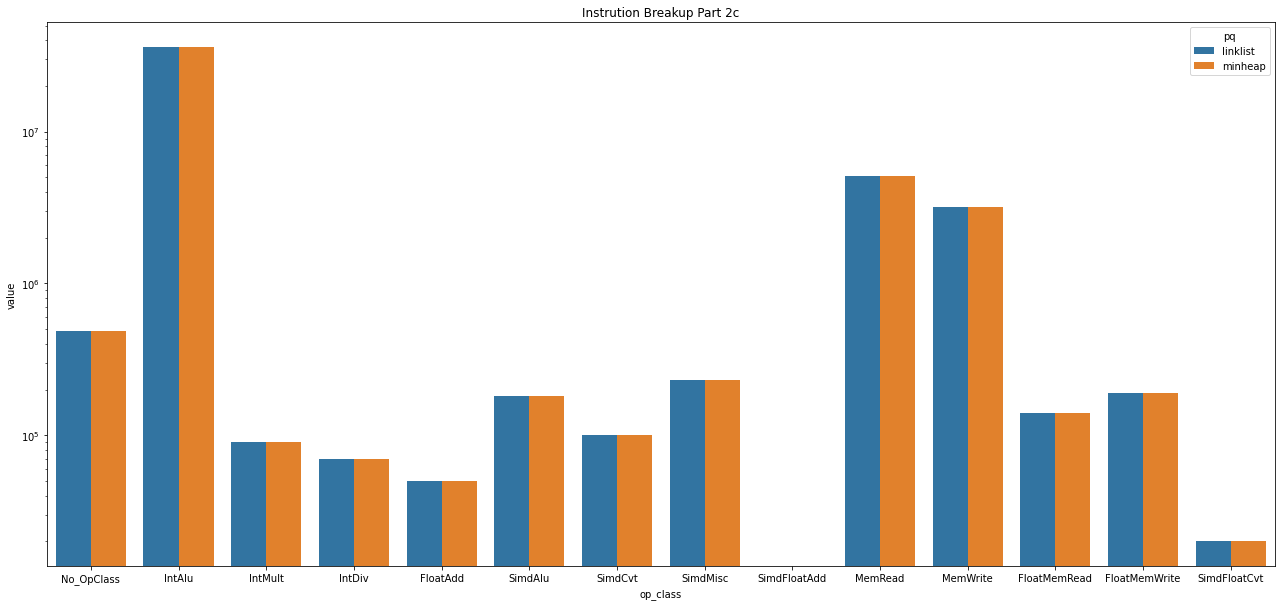

In [4]:
for part in df2.part.unique():
    q1b = df2.loc[(df2.n == 10000) & (df2.part == part)]
    sns.barplot(data=q1b, x='op_class', y='value', hue='pq', log=True)
    plt.title("Instrution Breakup Part 2" + part)
    plt.show()

As expected Part 2a and Part 2c are equivalent for each of the priority queue implementations because the only portion of the program that is different is the priority queue data structure to handle sorting the data as it is pushed and popped from the priority queue. The plot for Part 2b makes it explicitly clear what the differences are between the two data structures. The `linklist` data structure uses integers more for the operations and is required to read from memory more than `minheap`. We can see this because `linklist` has far more `FloatMemRead` and `SimdFloatCvt` instructions in order to operate with integers. The `minheap` approach does not require as many reads from memory and performs more floating point oprations (`FloatAdd`). The only downside to using `minheap` is the amount of times the data structure requires a write to memory (`FloatMemWrite`).

## 3. Pipeline Design Exploration
### Question 2: What are the L1 Cache Miss Rates?
In this next part, `p3`, we move away from the TimingSimpleCPU which does not use a pipeline to the X86MinorCPU which executes instructions in a pipelined fashion. Part 3 also adds cache to the architecture: 64kB Direct-Mapped L1 Data Cache, 32kB Direct-Mapped L1 Instruction Cache, 4MB 8-way Unified L2 Cache. An easy way to observe the cache miss rates for each of the priority queue implementations is to use a bar plot. **NOTE: These plots use a log scale on the y-axis.**

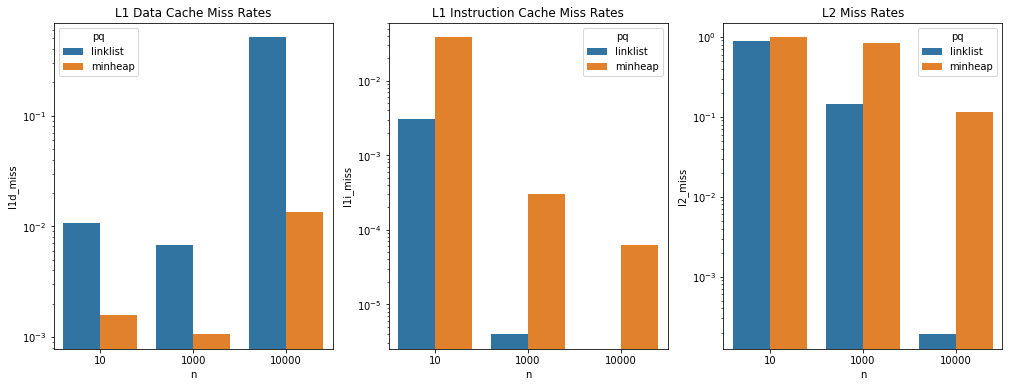

In [5]:
plt.rcParams["figure.figsize"] = (17, 6)
df3 = df.loc[df.part=='p3']
plt.subplot(1,3,1)
sns.barplot(data=df3, x='n', y='l1d_miss', hue='pq', log=True)
plt.title("L1 Data Cache Miss Rates")
plt.subplot(1,3,2)
sns.barplot(data=df3, x='n', y='l1i_miss', hue='pq', log=True)
plt.title("L1 Instruction Cache Miss Rates")
plt.subplot(1,3,3)
sns.barplot(data=df3, x='n', y='l2_miss', hue='pq', log=True)
plt.title("L2 Miss Rates")
plt.show()

It is apparent that `minheap` L1 data cache miss rate is significantly less than the `linklist` implementation. Additionally, the number of total L1 data cache accesses in the `minheap` implementation is a mere fraction compared to `linklist`, shown in the table below. Although `minheap` has a higher L1 instruction cache miss rate in the second plot, the count of instruction misses is a small fraction of the number of data misses. The ratio of L1 intruction cache misses to L1 data cache misses for `minheap` is shown in the table below. Due to this extremely low ratio, the higher L1 instruction cache miss rate of `minheap` is less significant compared to the L1 data cache miss rate. Lastly, although `linklist` had a lower L2 cache miss rate, the count of `linklist` L2 cache misses is the same as the number of `minheap` L2 cache misses, which indicates that `linklist` accessed the L2 cache significantly more. The examples in the table below come from the simulation where `n` = 10000 using the default operation and issue latencies.

| Cache Type | linklist | minheap |
| --- | --- | --- |
| L1 Data Accesses | 51,280,937 | 3,262,253 |
| L1 Instruction/Data Miss Ratio | 1.9e-7 | 2.5e-3 |
| L2 Unified Misses | 5,004 | 4,659 |

### Questions 3: Which Priority Queue Implementation is the Best?
An easy and simple way of answering this question is to visualize the simulation times for `n` = 10, 1,000 and 10,000 and compare both priority queue implementations. One interesting observation is that for small input values (`n` = 10), the `linklist` implementation runs faster than `minheap`. However, based on each of the cache miss observations noted in Question 2, coupled with the significant time savings for large `n`, we conclude that the `minheap` implementation performs better than the `linklist` data structure. 

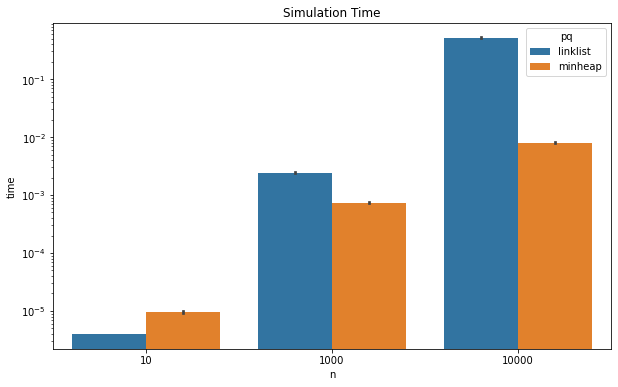

In [6]:
plt.rcParams["figure.figsize"] = (10, 6)
sns.barplot(data=df3, x='n', y='time', hue='pq', log=True)
plt.title("Simulation Time")
plt.show()

### Question 4: Which Design of the FloatSimd Functional Unit Would you Prefer?
For this question we will assume that the issue and operation latencies of the `FloatSimdFU` can vary from 1 to 6 cycles and that they always sum to 7 cycles. For each decrease in the opLat, we need to pay with a unit increase in issueLat. The enumerated combinations are:
- opLat = 6, issueLat = 1
- opLat = 5, issueLat = 2
- opLat = 4, issueLat = 3
- opLat = 3, issueLat = 4
- opLat = 2, issueLat = 5
- opLat = 1, issueLat = 6

We ran our simulation using `n` = 1000.

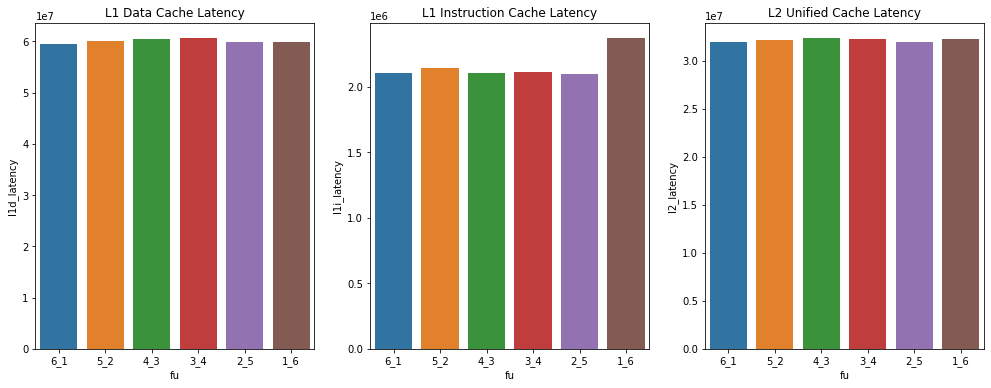

In [7]:
plt.rcParams["figure.figsize"] = (17, 6)
q3 = df3.loc[(df3.n == 1000) & (df3.fu != 'default')]
plt.subplot(1,3,1)
sns.barplot(data=q3, x='fu', y='l1d_latency', ci=None)
plt.title("L1 Data Cache Latency")
plt.subplot(1,3,2)
sns.barplot(data=q3, x='fu', y='l1i_latency', ci=None)
plt.title("L1 Instruction Cache Latency")
plt.subplot(1,3,3)
sns.barplot(data=q3, x='fu', y='l2_latency', ci=None)
plt.title("L2 Unified Cache Latency")
plt.show()

Although the differences are quite small and arguably negligible, based on our observations of the plots above, the best `FloatSimdFU` design is with an operational latency of 2 and an issue latency of 5 because it has the lowest L1 instruction and data cache latencies and the lowest L2 cache latency.

## 4. Function Unit Design Tradeoffs

### Question 5: Which Function Cycles Should we Halve?
In order to answer this question, we will assume our original X86MinorCPU design requires 2 cycles for integer functions and 4 cycles for floating point functions operation latencies (opLat). In a possible improvement to the X86MinorCPU, we can halve either of these latencies: integer or floating point. The issue latency will remain constant at the default of 1. The enumerated combinations are:
- Int = 2 cycles, FP = 4 cycles (this will be our baseline)
- Int = 1 cycles, FP = 4 cycles 
- Int = 2 cycles, FP = 2 cycles

We ran our simulation using `n` = 1000 and the default layout of the FloatSimdFU.

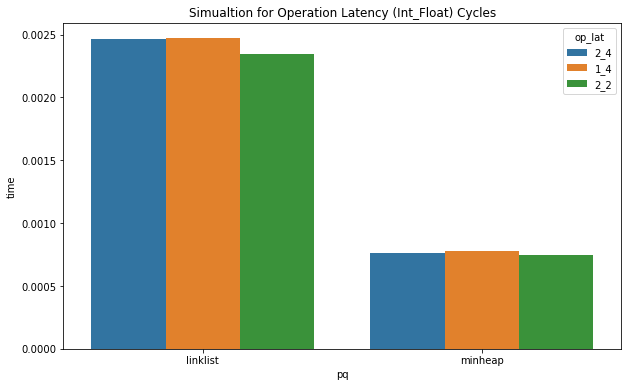

In [8]:
plt.rcParams["figure.figsize"] = (10, 6)
q4 = df.loc[df.part == 'p4']
sns.barplot(data=q4, x='pq', y='time', hue='op_lat')
plt.title("Simualtion for Operation Latency (Int_Float) Cycles")
plt.show()

Once again the results of the improvements are underwhelming and potentially negligible, however we would recommend halving the floating point function unit operational latency. This results in the green bar in the above bar plot (Int = 2 cycles, FP = 2 cycles).

## 5. Compiler Optimization
### Question 6: How Many Times Were Loops Unrolled?
A popular way to optimize a compiler is to reduce loop overhead by using loop unrolling. In this section we will examine how many times the loops in `main.c` are unrolled, as well as inspecting whether or not the loops in any of the `pq-*.c` implementations get unrolled. 

We compiled `main.c` and `pq-*.c` using the `-S` option in order to produce the assembly (`.s`) file output. We used [DiffChecker](https://www.diffchecker.com/) to oberve the differences between the assembly files witu and without loop unrolling. The loops in `main.c` to create the random array of values and priorities, sort the array using the priority queue push and pop functionality, as well as the printing loop were unrolled a total of 35 times. There were no observed differences in either `pq-*.s` files, suggesting the insertion sort while loop in `pq-linklist.c` and while loop to push a new item into the minheap priority queue in `pq-minheap.c` were not unrolled.

## 6. Effects of Loop Unrolling
### Questions 7: How does Loop Unrolling Affect Performance of this Implementation of the Sort Loop?

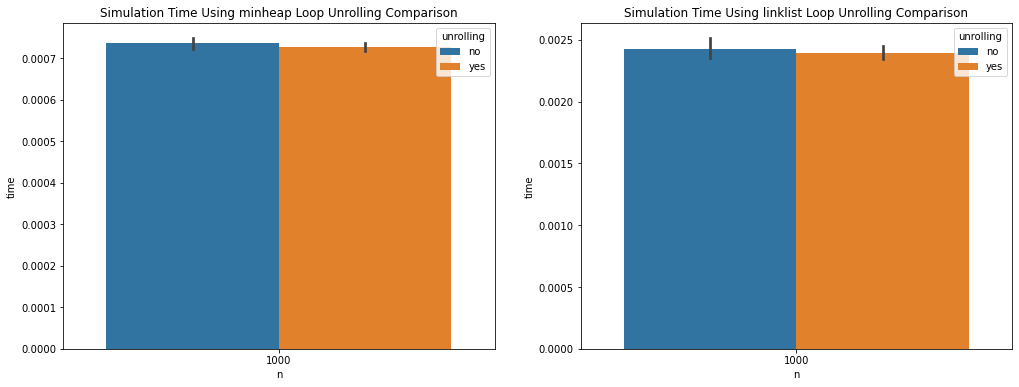

In [9]:
plt.rcParams["figure.figsize"] = (17, 6)
df5 = df.loc[df.part=='p5']
q7 = pd.concat([df3, df5])
q7 = q7.rename(columns={'part': 'unrolling'})
q7.unrolling = q7.unrolling.map({'p3': 'no', 'p5': 'yes'})
plt.subplot(1,2,1)
sns.barplot(data=q7.loc[(q7.n==1000) & (q7.pq=='minheap')], x='n', y='time', hue='unrolling')
plt.title("Simulation Time Using minheap Loop Unrolling Comparison")
plt.subplot(1,2,2)
sns.barplot(data=q7.loc[(q7.n==1000) & (q7.pq=='linklist')], x='n', y='time', hue='unrolling')
plt.title("Simulation Time Using linklist Loop Unrolling Comparison")
plt.show()

As illustrated in the plots above, loop unrolling provides a small efficiency improvement and a decrease in simulation time. The difference is fairly trivial, but this is most likely attributed to the greater efficiency improvements made by adding the `-O2` option.

### Questions 8: With Loop Unrolling, Which Priority Queue Implementation is the Best?

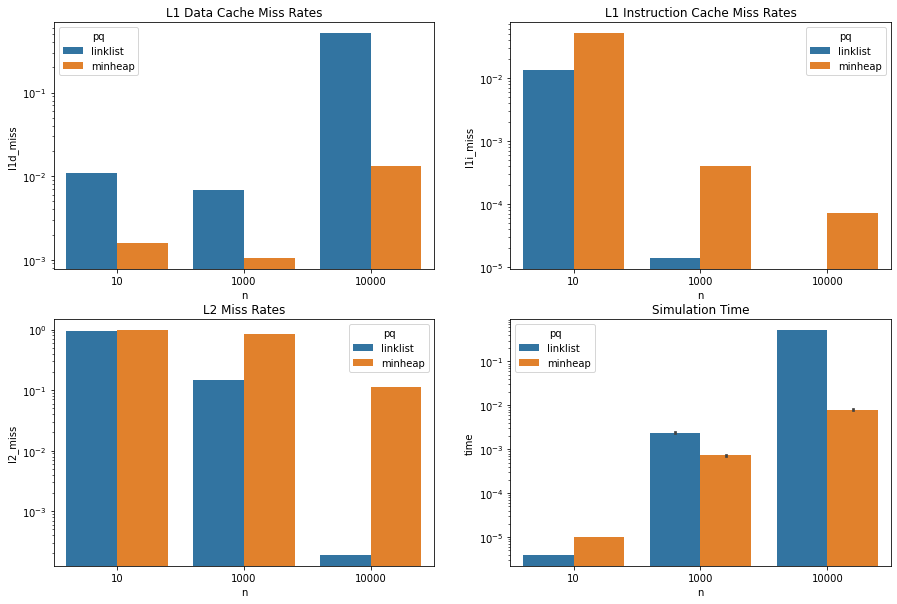

In [10]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.subplot(2,2,1)
sns.barplot(data=df5, x='n', y='l1d_miss', hue='pq', log=True)
plt.title("L1 Data Cache Miss Rates")
plt.subplot(2,2,2)
sns.barplot(data=df5, x='n', y='l1i_miss', hue='pq', log=True)
plt.title("L1 Instruction Cache Miss Rates")
plt.subplot(2,2,3)
sns.barplot(data=df5, x='n', y='l2_miss', hue='pq', log=True)
plt.title("L2 Miss Rates")
plt.subplot(2,2,4)
sns.barplot(data=df5, x='n', y='time', hue='pq', log=True)
plt.title("Simulation Time")
plt.show()

Based on these four plots, it appears that the `minheap` is still superior to `linklist` for the same reasons outlined in Part 3.

### Question 9: Do any Design Choices Change due to Loop Unrolling?
#### Operation Latency vs Issue Latency
We conducted additional simulations with loop unrolling to examine whether or not our design choices change for the operation
and issue latency tradeoff, as well as the opportunity to halve either the integer or floating point operation latency. To summarize the combinations, the tradeoff combinations of operation and issue latency are:
- opLat = 6, issueLat = 1
- opLat = 5, issueLat = 2
- opLat = 4, issueLat = 3
- opLat = 3, issueLat = 4
- opLat = 2, issueLat = 5
- opLat = 1, issueLat = 6

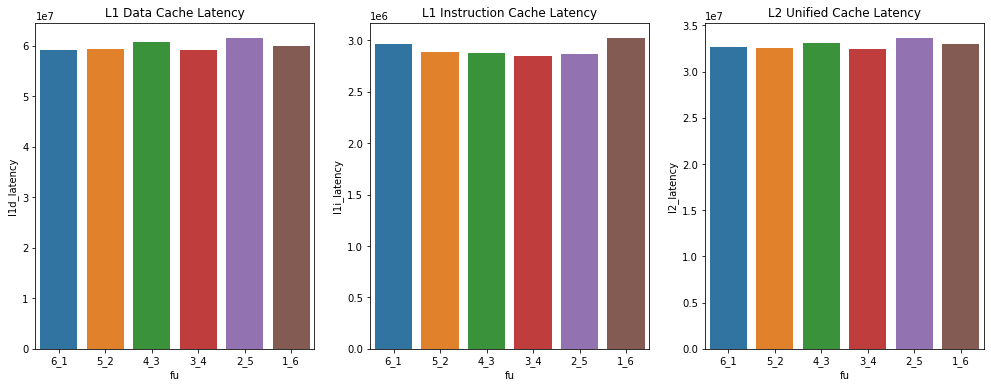

In [11]:
plt.rcParams["figure.figsize"] = (17, 6)
q7 = df5.loc[(df5.n == 1000) & (df5.fu != 'default')]
plt.subplot(1,3,1)
sns.barplot(data=q7, x='fu', y='l1d_latency', ci=None)
plt.title("L1 Data Cache Latency")
plt.subplot(1,3,2)
sns.barplot(data=q7, x='fu', y='l1i_latency', ci=None)
plt.title("L1 Instruction Cache Latency")
plt.subplot(1,3,3)
sns.barplot(data=q7, x='fu', y='l2_latency', ci=None)
plt.title("L2 Unified Cache Latency")
plt.show()

It appears that the `FloatSimdFU` design that performs the best is now `3_4` which represents an operation latency of 3 and an issue latency of 4. This design was almost the best in Part 4 as well. 

#### Halve Integer or Float Operation Latency
The options for halving operation latencies are:
- Int = 2 cycles, FP = 4 cycles (this will be our baseline)
- Int = 1 cycles, FP = 4 cycles 
- Int = 2 cycles, FP = 2 cycles

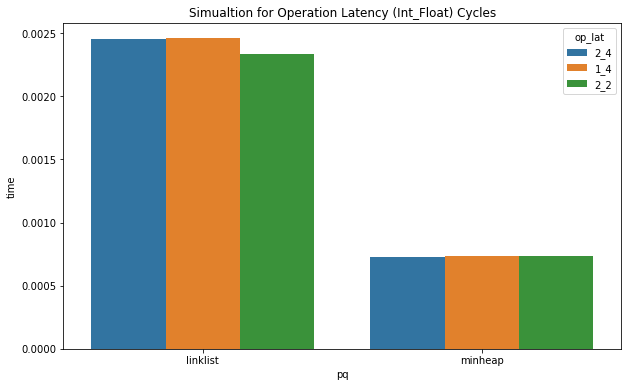

In [12]:
plt.rcParams["figure.figsize"] = (10, 6)
q7b = df5.loc[df5.op_lat != 'default']
sns.barplot(data=q7b, x='pq', y='time', hue='op_lat')
plt.title("Simualtion for Operation Latency (Int_Float) Cycles")
plt.show()

Halving the FP operation latency seems to have a great impact on the simulation time for `linklist`, but less of an improvement for `minheap`. Choosing to allocate resources to halve the FP operation latency still seems like the the correct choice. 

## 7. Conclusion
In conclusion, this project highlighted the differences in priority queue implementations, namely the instruction breakup, cache miss rates, and simualtion time. We observed the `minheap` data structure outperform a `linklist` in almost every way. The only exception to this is when the priority queue is small (`n` = 1000). We observed that changing the number of cycles for the functional unit latencies has a marginal effect on system performance for both the integer and floating point functional units. We decided that the best `FloatSimdFU` latency option was  an operational latency of 2 and an issue latency of 5. Additionally, the best operation latency to halve is the floating point operation latency dude to the greater amount of `FP` and `SIMD` operations compared to `Int`. Lastly, we discovered that unrolling loops does provide a small increase in performance by reducing simulation time and that the addition of loop unrolling does not have a significant effect on our design choices.